## Importing the libraries

In [26]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

DEVICE = "cpu"

## Load the dataset

In [27]:
NUM_CLIENTS = 10
BATCH_SIZE = 32


def load_datasets(partition_id: int):
    #Load the cifar-10 dataset while partitioning it into num_clients parts
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": NUM_CLIENTS})

    #find the partition corresponding to partition_id
    partition = fds.load_partition(partition_id)
    
    #Split partition into training and test set
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)

    #Apply transformation to partition_train_test for better training results
    #toTensor converts in range [0, 1] while normalize converts in range [-1, 1]
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch
    partition_train_test = partition_train_test.with_transform(apply_transforms)

    #Retrieve the training, validation and test dataset
    trainloader = DataLoader(
        partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True
    )
    valloader = DataLoader(
        partition_train_test["test"], batch_size=BATCH_SIZE
    )
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(
        testset, batch_size=BATCH_SIZE
    )

    return trainloader, valloader, testloader

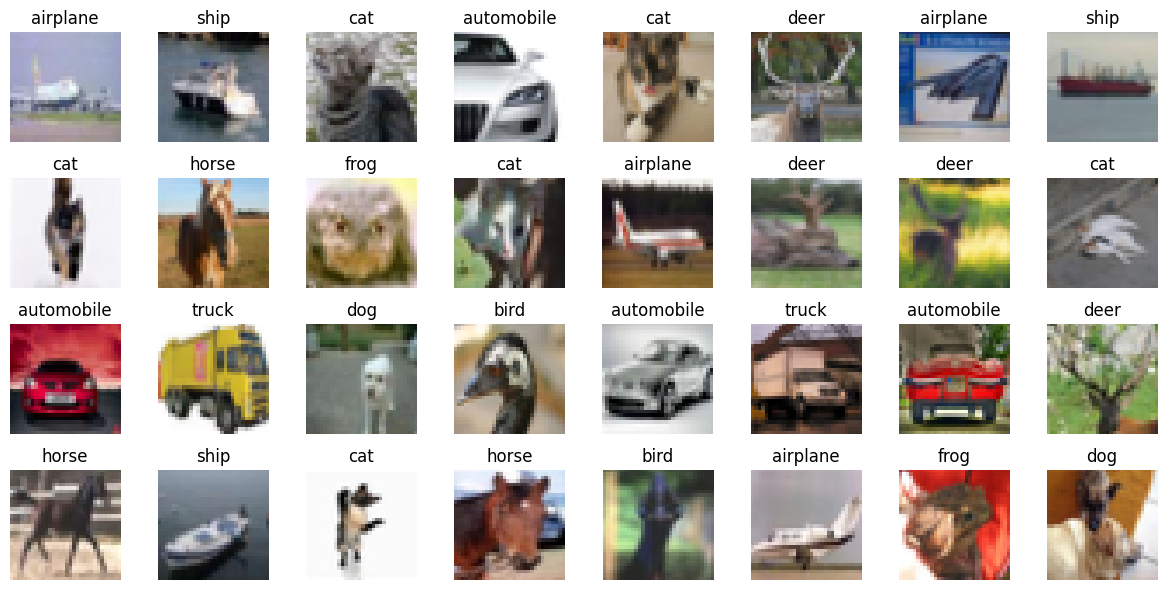

In [28]:
trainloader, _, _ = load_datasets(partition_id=0)
batch = next(iter(trainloader))
images, labels = batch["img"], batch["label"]

# matplotlib expects images to be in (B, H, W, C) format while pytorch returns in (B, C, H, W) format
images = images.permute(0, 2, 3, 1).numpy()

# Denormalize
images = images / 2 + 0.5 

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(trainloader.dataset.features["label"].int2str([labels[i]])[0])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

## Centralized Training


### Define the model

In [29]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [30]:
def train(net, trainloader, verbose=False):    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()

    correct, total, epoch_loss = 0, 0, 0.0

    for batch in trainloader:
        images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
        optimizer.zero_grad()
        outputs = net(images)

        loss = criterion(outputs, labels)

        # Update model parameters
        loss.backward()
        optimizer.step()
            
        epoch_loss += loss.item()
        total += labels.size(0)
        correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
            
    epoch_loss /= len(trainloader.dataset)
    epoch_acc = correct / total

    if verbose:
        print(f"train loss {epoch_loss}, accuracy {epoch_acc}")

    return epoch_loss, epoch_acc


def test(net, testloader):
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)

            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

### Train the model 

In [49]:
trainloader, valloader, testloader = load_datasets(partition_id=0)
net = Net().to(DEVICE)

history = {
    "round": [],
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
}

for epoch in range(5):
    trainLoss, trainAccuracy = train(net, trainloader)
    valLoss, valAccuracy = test(net, valloader)

    history["round"].append(epoch + 1)

    history["train_loss"].append(trainLoss)
    history["train_accuracy"].append(trainAccuracy)

    history["val_loss"].append(valLoss)
    history["val_accuracy"].append(valAccuracy)
    
    print(f"Epoch: {epoch+1}")
    print(f"train loss {trainLoss}, accuracy {trainAccuracy}")
    print(f"validation loss {valLoss}, accuracy {valAccuracy}\n")

loss, accuracy = test(net, testloader)
print(f"\nFinal test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch: 1
train loss 0.06540031158924103, accuracy 0.22925
validation loss 0.061530036449432376, accuracy 0.304

Epoch: 2
train loss 0.058447580575942994, accuracy 0.31
validation loss 0.05806905472278595, accuracy 0.357

Epoch: 3
train loss 0.054217956215143207, accuracy 0.37225
validation loss 0.05315118193626404, accuracy 0.388

Epoch: 4
train loss 0.05114075475931167, accuracy 0.402
validation loss 0.05017423474788666, accuracy 0.419

Epoch: 5
train loss 0.0490934436917305, accuracy 0.43375
validation loss 0.05001613438129425, accuracy 0.427


Final test set performance:
	loss 0.05009497013092041
	accuracy 0.4081


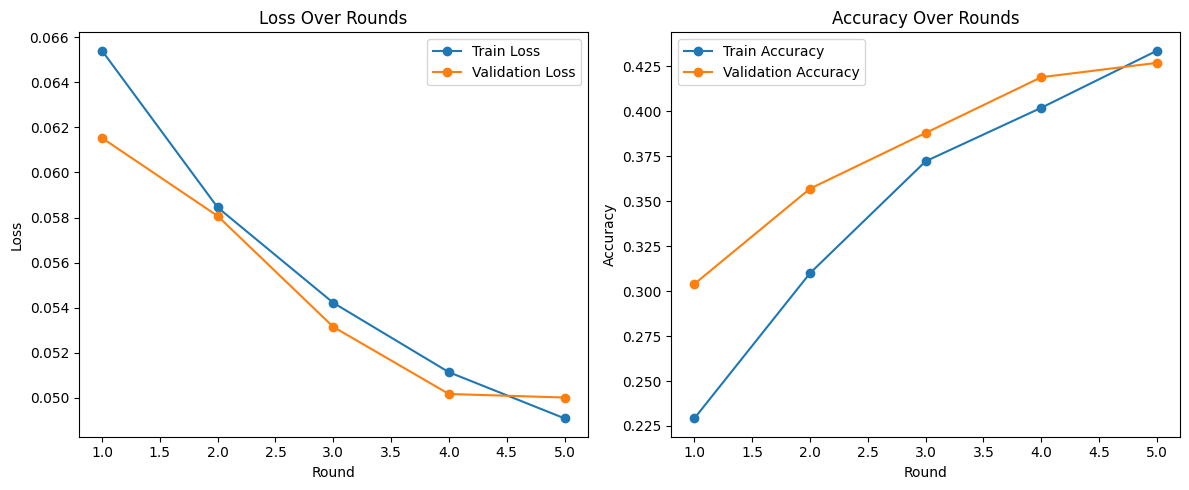

In [50]:
import matplotlib.pyplot as plt

def filter_none(x, y):
    """Remove None values from x and y while keeping their relationship."""
    filtered = [(xi, yi) for xi, yi in zip(x, y) if yi is not None]
    return zip(*filtered) if filtered else ([], [])

def plot_metrics(history):
    if not history["round"]:
        print("No data to plot. Ensure training rounds have completed.")
        return

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    rounds_loss, train_loss = filter_none(history["round"], history["train_loss"])
    rounds_val_loss, val_loss = filter_none(history["round"], history["val_loss"])
    
    plt.plot(rounds_loss, train_loss, label="Train Loss", marker="o")
    plt.plot(rounds_val_loss, val_loss, label="Validation Loss", marker="o")
    
    plt.xlabel("Round")
    plt.ylabel("Loss")
    plt.title("Loss Over Rounds")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    rounds_acc, train_acc = filter_none(history["round"], history["train_accuracy"])
    rounds_val_acc, val_acc = filter_none(history["round"], history["val_accuracy"])
    
    plt.plot(rounds_acc, train_acc, label="Train Accuracy", marker="o")
    plt.plot(rounds_val_acc, val_acc, label="Validation Accuracy", marker="o")

    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Rounds")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Run the function
plot_metrics(history)


## Federated Learning with Flower

### Update Model Parameter

In [36]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

### Define the client

In [37]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train_loss, train_accuracy = train(self.net, self.trainloader)
        return get_parameters(self.net), len(self.trainloader), {"train_loss": train_loss, "train_accuracy": train_accuracy}


    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        # Evaluate the model
        val_loss, val_accuracy = test(self.net, self.valloader)

        # Return evaluation metrics
        return float(val_loss), len(self.valloader), {"accuracy": float(val_accuracy), "val_loss": float(val_loss)}

In [38]:
# client_fn is used to make a Flower client only upon need and then discard it
def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)

    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)

    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client() to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

## Define the server

In [51]:
from flwr.server.strategy import FedAvg
from flwr.common import Scalar
from typing import Dict, List, Tuple, Optional

# Define a global history dictionary to store metrics
history = {
    "round": [],
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
}

# Function to update the history
def update_history(server_round, avg_train_loss, avg_train_accuracy, avg_val_loss, avg_val_accuracy):
    history["round"].append(server_round)
    history["train_loss"].append(avg_train_loss)
    history["train_accuracy"].append(avg_train_accuracy)
    history["val_loss"].append(avg_val_loss)
    history["val_accuracy"].append(avg_val_accuracy)

class CustomFedAvg(FedAvg):
    def aggregate_fit(self, server_round, results, failures):
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

        # Count the number of participating clients
        num_clients = len(results)
        
        # Store number of clients
        if "num_clients" not in history:
            history["num_clients"] = []
        history["num_clients"].append(num_clients)

        # Extract metrics
        train_losses = [fit_res.metrics["train_loss"] for _, fit_res in results if "train_loss" in fit_res.metrics]
        train_accuracies = [fit_res.metrics["train_accuracy"] for _, fit_res in results if "train_accuracy" in fit_res.metrics]

        avg_train_loss = sum(train_losses) / len(train_losses) if train_losses else 0
        avg_train_accuracy = sum(train_accuracies) / len(train_accuracies) if train_accuracies else 0

        print(f"Round {server_round}: Clients = {num_clients}, Train Loss = {avg_train_loss}, Train Acc = {avg_train_accuracy}")

        update_history(server_round, avg_train_loss, avg_train_accuracy, None, None)

        return aggregated_parameters, aggregated_metrics

    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_loss, aggregated_metrics = super().aggregate_evaluate(server_round, results, failures)

        num_clients = len(results)  # Clients who participated in evaluation
        history["num_clients"].append(num_clients)

        val_losses = [eval_res.metrics["val_loss"] for _, eval_res in results if "val_loss" in eval_res.metrics]
        val_accuracies = [eval_res.metrics["accuracy"] for _, eval_res in results if "accuracy" in eval_res.metrics]

        avg_val_loss = sum(val_losses) / len(val_losses) if val_losses else 0
        avg_val_accuracy = sum(val_accuracies) / len(val_accuracies) if val_accuracies else 0

        print(f"Round {server_round}: Clients = {num_clients}, Val Loss = {avg_val_loss}, Val Acc = {avg_val_accuracy}")

        update_history(server_round, None, None, avg_val_loss, avg_val_accuracy)

        return aggregated_loss, aggregated_metrics


In [ ]:
def fit_config(server_round: int):
    return {"learning_rate": 0.01 * (0.98 ** server_round)}

strategy = CustomFedAvg(
    fraction_fit=0.5,
    fraction_evaluate=0.5,
    min_fit_clients=5,
    min_evaluate_clients=3,
    min_available_clients=5,
    on_fit_config_fn=fit_config
)


In [53]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use the settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=5)

    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

## Training

In [54]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

In [ ]:
import os
import tensorflow as tf
import warnings
import logging

# Suppress all DeprecationWarnings
warnings.simplefilter("ignore", DeprecationWarning) 
warnings.filterwarnings("ignore")

# Suppress all info & warning messages (only errors remain)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.get_logger().setLevel("ERROR")


# Suppress Ray logs
logging.getLogger("ray").setLevel(logging.ERROR)
# If running in a script, ensure logging is applied globally
logging.basicConfig(level=logging.ERROR)

# Run simulation


INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(ClientAppActor pid=3508) c:\Users\Mridul\AppData\Local\Programs\Python\Python312\Lib\site-packages\datasets\utils\_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=3508)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(ClientAppActor pid=11224) c:\Users\Mridul\AppData\Local\Programs\Python\Python312\Lib\site-packages\datasets\utils\_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=11224)   obj.co_lnotab,  # for < python 3.10 [not

Round 1: Clients = 4, Train Loss = 0.06449208192527295, Train Acc = 0.2196875


(ClientAppActor pid=20500) c:\Users\Mridul\AppData\Local\Programs\Python\Python312\Lib\site-packages\datasets\utils\_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=20500)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


Round 1: Clients = 5, Val Loss = 0.06202887015342713, Val Acc = 0.29419999999999996


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Round 2: Clients = 5, Train Loss = 0.05768222109675407, Train Acc = 0.31255


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


Round 2: Clients = 5, Val Loss = 0.05602931332588196, Val Acc = 0.34859999999999997


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Round 3: Clients = 5, Train Loss = 0.054597848910093304, Train Acc = 0.34859999999999997


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


Round 3: Clients = 5, Val Loss = 0.05297626321315765, Val Acc = 0.3936


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Round 4: Clients = 5, Train Loss = 0.051940860354900364, Train Acc = 0.38505


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


Round 4: Clients = 5, Val Loss = 0.05110508408546448, Val Acc = 0.4084


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Round 5: Clients = 5, Train Loss = 0.04984422048330307, Train Acc = 0.4138


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 294.53s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06202887015342713
INFO :      		round 2: 0.05602931332588196
INFO :      		round 3: 0.05297626321315765
INFO :      		round 4: 0.05110508408546448
INFO :      		round 5: 0.049715063858032225
INFO :      


Round 5: Clients = 5, Val Loss = 0.049715063858032225, Val Acc = 0.4258


(ClientAppActor pid=11224) WARNING :   Manually terminating ClientAppActor


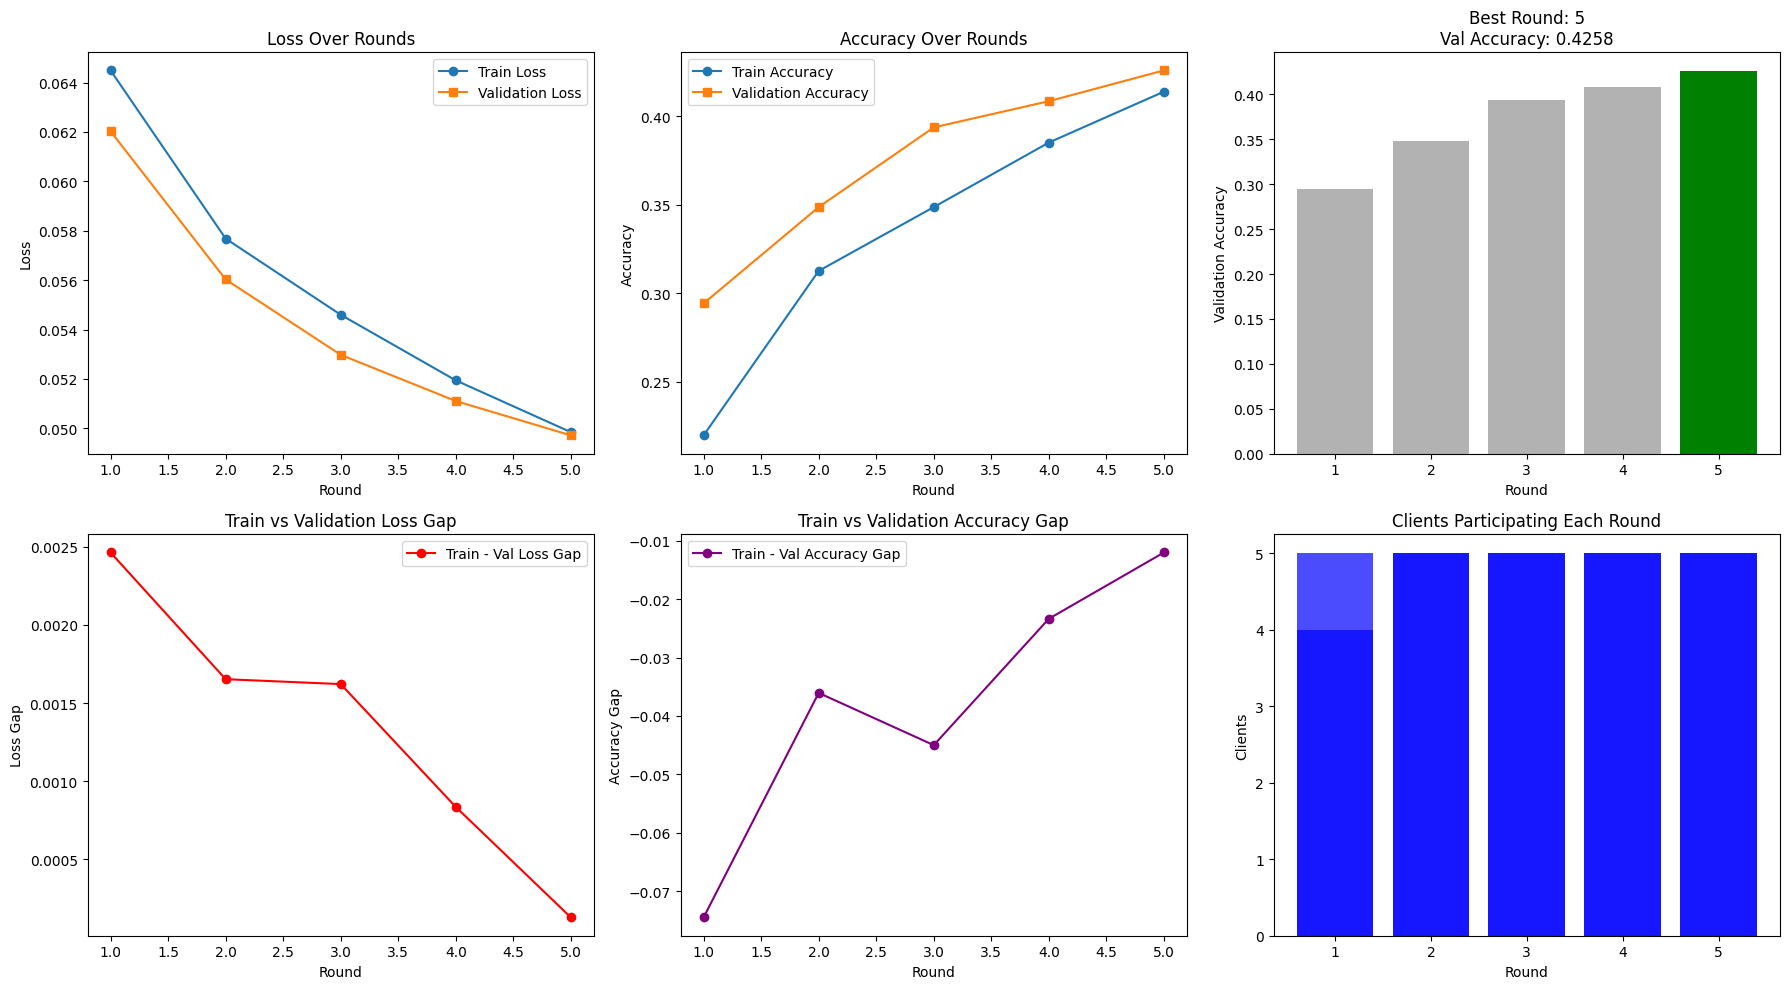

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def filter_none(x_list, y_list):
    """Helper function to remove None values from lists."""
    filtered_x, filtered_y = zip(*[(x, y) for x, y in zip(x_list, y_list) if y is not None])
    return list(filtered_x), list(filtered_y)

def plot_dashboard(history, num_clients_per_round=None):
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    
    # === Loss over Rounds ===
    rounds_loss, train_loss = filter_none(history["round"], history["train_loss"])
    rounds_val_loss, val_loss = filter_none(history["round"], history["val_loss"])
    
    axs[0, 0].plot(rounds_loss, train_loss, label="Train Loss", marker="o")
    axs[0, 0].plot(rounds_val_loss, val_loss, label="Validation Loss", marker="s")
    axs[0, 0].set_title("Loss Over Rounds")
    axs[0, 0].set_xlabel("Round")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()
    
    # === Accuracy over Rounds ===
    rounds_acc, train_acc = filter_none(history["round"], history["train_accuracy"])
    rounds_val_acc, val_acc = filter_none(history["round"], history["val_accuracy"])
    
    axs[0, 1].plot(rounds_acc, train_acc, label="Train Accuracy", marker="o")
    axs[0, 1].plot(rounds_val_acc, val_acc, label="Validation Accuracy", marker="s")
    axs[0, 1].set_title("Accuracy Over Rounds")
    axs[0, 1].set_xlabel("Round")
    axs[0, 1].set_ylabel("Accuracy")
    axs[0, 1].legend()

    # === Loss Gap (Train - Val) ===
    loss_gap = [tl - vl for tl, vl in zip(train_loss, val_loss)]
    axs[1, 0].plot(rounds_loss, loss_gap, label="Train - Val Loss Gap", marker="o", color="red")
    axs[1, 0].set_title("Train vs Validation Loss Gap")
    axs[1, 0].set_xlabel("Round")
    axs[1, 0].set_ylabel("Loss Gap")
    axs[1, 0].legend()
    
    # === Accuracy Gap (Train - Val) ===
    acc_gap = [ta - va for ta, va in zip(train_acc, val_acc)]
    axs[1, 1].plot(rounds_acc, acc_gap, label="Train - Val Accuracy Gap", marker="o", color="purple")
    axs[1, 1].set_title("Train vs Validation Accuracy Gap")
    axs[1, 1].set_xlabel("Round")
    axs[1, 1].set_ylabel("Accuracy Gap")
    axs[1, 1].legend()
    
    # === Best Round Highlight ===
    best_index = val_acc.index(max(val_acc))
    best_round = rounds_val_acc[best_index]
    axs[0, 2].bar(rounds_val_acc, val_acc, color="gray", alpha=0.6)
    axs[0, 2].bar(best_round, val_acc[best_index], color="green")
    axs[0, 2].set_title(f"Best Round: {best_round}\nVal Accuracy: {val_acc[best_index]:.4f}")
    axs[0, 2].set_xlabel("Round")
    axs[0, 2].set_ylabel("Validation Accuracy")

    # === Clients per Round (if provided) ===
    if num_clients_per_round:
        axs[1, 2].bar(history["round"], num_clients_per_round, color="blue", alpha=0.7)
        axs[1, 2].set_title("Clients Participating Each Round")
        axs[1, 2].set_xlabel("Round")
        axs[1, 2].set_ylabel("Clients")

    plt.tight_layout()
    plt.show()

plot_dashboard(history, num_clients_per_round=history["num_clients"])